### Facet AFM -> Point Cloud Plot -> TDA

In [98]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, MeanShift, OPTICS, MiniBatchKMeans

from ripser import ripser
from persim import plot_diagrams

In [99]:
def read_AFM_XYZ(filepath):
    filepath = Path(filepath)
    xyz = None
    if filepath.suffix == ".xyz" or filepath.suffix == ".XYZ":
        xyz = np.genfromtxt(filepath, skip_header=0, usecols=(0, 1, 2))
        
        # Create a mask to filter rows based on the specified conditions
        mask = [(row[0] >= 0) and (row[1] >= 0) for row in xyz]
        xyz = [list(row) for row, keep in zip(xyz, mask) if keep]
        xyz = np.array(xyz)  # Convert to a NumPy array
        norm = np.linalg.norm(xyz)
        xyz = xyz/norm
        # Sort based on the first column (x)
        xyz = xyz[xyz[:, 0].argsort()]
    return xyz

In [100]:
# Possibly not the best clustering algo for this

def determine_modal_values(point_cloud, epsilon=0.001, min_samples=5):
    z_values = point_cloud[:, 2]
    z_values = z_values.reshape(-1, 1)  # Reshape for DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(z_values)
    modal_values = np.unique(z_values[dbscan.labels_ != -1])
    modal_values = np.sort(modal_values)  # Sort the modal values
    print(modal_values)
    return modal_values

def round_noisy_points(point_cloud, modal_values):
    rounded_points = []
    for point in point_cloud:
        rounded_z = min(modal_values, key=lambda x: abs(x - point[2]))
        rounded_point = [point[0], point[1], rounded_z]
        rounded_points.append(rounded_point)
    print(rounded_points)
    return np.array(rounded_points)

In [101]:
def mean_shift(point_cloud, bandwidth):
    # Create a Mean Shift clustering model
    ms = MeanShift(bandwidth=bandwidth)
    
    # Fit the model to the z-values of the point cloud
    z_values = point_cloud[:, 2].reshape(-1, 1)
    ms.fit(z_values)
    # Determine the cluster centers (modal z-values)
    modal_values = ms.cluster_centers_.flatten()

    # Round the z-values based on the modal z-values
    rounded_points = []
    for point in point_cloud:
        closest_modal_z = min(modal_values, key=lambda z: abs(z - point[2]))
        rounded_point = [point[0], point[1], closest_modal_z]
        rounded_points.append(rounded_point)

    return np.array(rounded_points)

In [102]:
def plot_afm_3d(filtered_xyz):
    
    x, y, z = [filtered_xyz[:, i] for i in range(3)]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colormap = plt.get_cmap("viridis")

    plt.rcParams["figure.figsize"] = [4.0, 4.0]
    plt.rcParams["figure.autolayout"] = True
    
    # Normalize the 'colour' column to map it to the colormap
    norm = plt.Normalize(z.min(), z.max())

    scatter = ax.scatter(x, y, z, c=z, norm=norm, cmap=colormap, marker=",", s=0.1)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Color Label")
    
    ax.view_init(45, 60)

    plt.tight_layout()

    plt.show()

[[3.10959090e-06 5.91022772e-03 1.85517438e-05]
 [3.10959090e-06 5.55810790e-03 3.71034875e-05]
 [3.10959090e-06 7.19442944e-03 9.27607900e-06]
 ...
 [1.21481340e-03 7.31870703e-03 9.27607900e-06]
 [1.21481340e-03 7.25656824e-03 9.27607900e-06]
 [1.21481340e-03 7.26692470e-03 9.27607900e-06]]


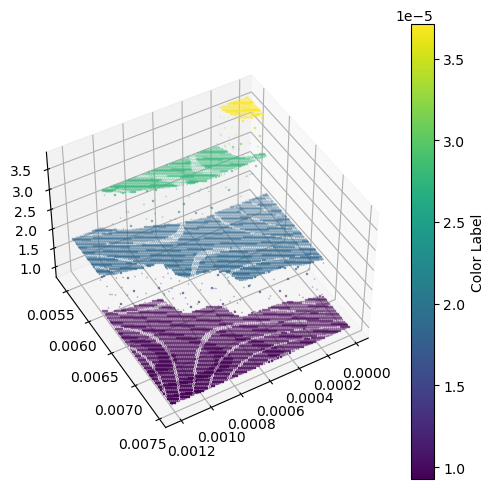

In [103]:
afm = read_AFM_XYZ('/Users/user/Documents/PhD/AFML/AFML/sample_preproc_data/terrace_sample/save-2011.11.30-14.25.48_terrace_200.xyz')
print(afm)
plot_afm_3d(afm)

Note - runtime for mean_shift is ~36seconds for this (23600, 3)/~153x153point/200x200 micrograph. ? Scaling for original AFM? Choice of acquisition resolution from instrument - limit to 256x256?

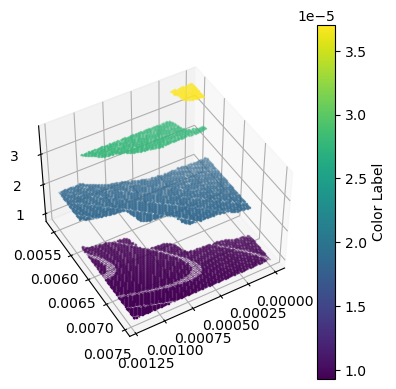

In [104]:
rounded_afm = mean_shift(afm, bandwidth=0.00000475)
plot_afm_3d(rounded_afm)

In [105]:
original_afm = read_AFM_XYZ('/Users/user/Documents/PhD/AFML/AFML/sample_preproc_data/terrace_sample/save-2011.11.30-14.25.48_terrace_IDEAL.xyz')
print(original_afm.shape)
print(afm.shape)
print(rounded_afm.shape)

(154624, 3)
(23600, 3)
(23600, 3)


Downsampling time - Need to reduce our point cloud of size (154624, 3) or (23600, 3) -> (1354, 3)

FIrst - NEED to address which terraces belong to which cluster?

In [106]:
unique_z_values = set(point[2] for point in rounded_afm)

print(len(unique_z_values))
print(unique_z_values)

4
{9.290414944757932e-06, 2.7803237622819897e-05, 3.703497693922487e-05, 1.8543724365542377e-05}


Assign a 'terrace label' to each point in the point cloud depending on z-label - DON'T EVEN NEED THIS!

In [107]:
"""def assign_terraces(data):
    # Sort the data based on the Z-values
    sorted_data = sorted(data, key=lambda point: point[2])

    # Initialize the label counter and the labeled data
    label_counter = 0
    labeled_data = []

    # Assign labels in ascending order based on Z-values
    current_z_value = None
    for point in sorted_data:
        x, y, z = point
        if z != current_z_value:
            label_counter += 1
            current_z_value = z
        labeled_data.append([label_counter, x, y, z])

    return labeled_data"""

'def assign_terraces(data):\n    # Sort the data based on the Z-values\n    sorted_data = sorted(data, key=lambda point: point[2])\n\n    # Initialize the label counter and the labeled data\n    label_counter = 0\n    labeled_data = []\n\n    # Assign labels in ascending order based on Z-values\n    current_z_value = None\n    for point in sorted_data:\n        x, y, z = point\n        if z != current_z_value:\n            label_counter += 1\n            current_z_value = z\n        labeled_data.append([label_counter, x, y, z])\n\n    return labeled_data'

In [108]:
"""rounded_afm = assign_terraces(rounded_afm)
unique_terraces = set(point[0] for point in rounded_afm)
print(len(unique_terraces))
print(unique_terraces)"""

'rounded_afm = assign_terraces(rounded_afm)\nunique_terraces = set(point[0] for point in rounded_afm)\nprint(len(unique_terraces))\nprint(unique_terraces)'

Using OPTICS to downsample our point cloud but retain shape...

In [109]:
"""def downsample_point_cloud(point_cloud_data, desired_num_points, min_samples=5, xi=0.05, min_cluster_size=10):
    
    Downsample a point cloud to a specified number of points using OPTICS clustering.

    Parameters:
    - point_cloud_data: The input point cloud data as a NumPy array or list.
    - desired_num_points: The desired number of points in the downsampled point cloud.
    - min_samples: The minimum number of samples for OPTICS clustering (default: 5).
    - xi: The Xi parameter for OPTICS clustering (default: 0.05).
    - min_cluster_size: The minimum cluster size for OPTICS clustering (default: 10).

    Returns:
    - downsampled_point_cloud: The downsampled point cloud as a NumPy array.
    

    # Create an OPTICS model with the specified parameters
    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)

    # Fit the model to the input point cloud data
    optics.fit(point_cloud_data)

    # Initialize variables for tracking the selected clusters and points
    selected_clusters = []
    num_selected_points = 0

    # Traverse the cluster hierarchy and select clusters with enough points
    for cluster in optics.cluster_hierarchy_:
        if num_selected_points >= desired_num_points:
            break

        if cluster.size >= min_cluster_size:
            selected_clusters.append(cluster)
            num_selected_points += cluster.size

    # Extract representative points from the selected clusters
    downsampled_point_cloud = []
    for cluster in selected_clusters:
        cluster_center = cluster.cluster_center_
        downsampled_point_cloud.append(cluster_center)

    # Convert the result to a NumPy array
    downsampled_point_cloud = np.array(downsampled_point_cloud)

    return downsampled_point_cloud"""

'def downsample_point_cloud(point_cloud_data, desired_num_points, min_samples=5, xi=0.05, min_cluster_size=10):\n    \n    Downsample a point cloud to a specified number of points using OPTICS clustering.\n\n    Parameters:\n    - point_cloud_data: The input point cloud data as a NumPy array or list.\n    - desired_num_points: The desired number of points in the downsampled point cloud.\n    - min_samples: The minimum number of samples for OPTICS clustering (default: 5).\n    - xi: The Xi parameter for OPTICS clustering (default: 0.05).\n    - min_cluster_size: The minimum cluster size for OPTICS clustering (default: 10).\n\n    Returns:\n    - downsampled_point_cloud: The downsampled point cloud as a NumPy array.\n    \n\n    # Create an OPTICS model with the specified parameters\n    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)\n\n    # Fit the model to the input point cloud data\n    optics.fit(point_cloud_data)\n\n    # Initialize variables for

In [110]:
mbk = MiniBatchKMeans(init="k-means++", n_clusters=512, batch_size=1024, n_init=10, max_no_improvement=10, verbose=0)
mbk.fit(rounded_afm)
downsampled_afm = mbk.cluster_centers_

[[4.31822034e-04 6.37871395e-03 1.85437244e-05]
 [9.60233880e-04 5.86250675e-03 1.85437244e-05]
 [9.30317610e-04 7.17723689e-03 9.29041494e-06]
 ...
 [1.12730353e-03 5.43875981e-03 1.85437244e-05]
 [1.03246032e-03 6.70331495e-03 9.29041494e-06]
 [1.30288478e-04 7.45347917e-03 9.29041494e-06]]


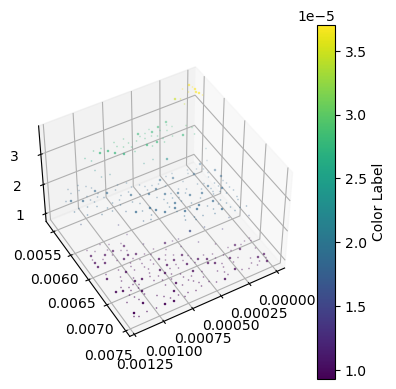

In [111]:
print(downsampled_afm)
plot_afm_3d(downsampled_afm)

So this is NOT sufficient - could remove z-dimension from model possibly but the array of data points is not ordered - this will have a different neighbourhood shape via TDA than our simulation data which is ordered...